<h1><center>Call Center Test Results</center></h1>

|          Metric          |                          Definition                         |                                Formula                                |
|:------------------------:|:-----------------------------------------------------------:|:---------------------------------------------------------------------:|
|       Calls Handled      |                Inbound call taken by an agent               |                          Sum of Calls Handled                         |
| Avg Handle Time (or AHT) |               Average time to complete a call               |                      Handle Time / Calls Handled                      |
|        Transfer %        |       Percent of calls that resulted in a transfer out      |                       Transfers / Calls Handled                       |
|          Offer %         |               Percent of offers made on a call              |                  Calls with an Offer / Calls Handled                  |
|         Accept %         |              Percent of accepts on offers made              |               Calls with an Accept / Calls with an Offer              |
|         Applied %        |            Percent of applieds on accepted offers           |              Calls with an Applied / Calls with an Accept             |
|         Breakage         |       Percent of calls where an offer was not applied       | (Calls with an Accept - Calls with an Applied) / Calls with an Accept |
|     Applied Per Call     |          Percent of calls that had an applied offer         |                 Calls with an Applied / Calls Handled                 |
|  Callback within 2 Days  | Percent of calls where customer called back within 48 hours |                       Call Regen / Calls Handled                      |

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
#reading raw data from call center dataset
data = pd.read_csv("D:/datasets/callcentre/rawdata.csv")

In [3]:
#an overview of the dataset
data.head()

,YR_MO,CALL_DATE,AGENT_ID,AGENT_NAME,TEAM_LEAD_ID,TEAM_LEAD_NAME,CALL_CENTER,CALLS,HANDLE_TIME,CALL_REGEN,CALLS_WITH_OFFER,CALLS_WITH_ACCEPT,CALLS_OFFER_APPLIED,TRANSFERS,AHT_MULTI,CALL_REGEN_MULTI,TRANSFERS_MULTI,APPLIED_PER_CALL_MULTI,BREAKAGE_MULTI
0,201706,01-06-2017,201700121,"Anderson, Albert",201700011,"Winnerson, Aceona",Williamburg,34,25710,5,31,22,19,2,26520,5.678,2.788,17.170,6.834
1,201706,01-06-2017,201700122,"Binning, Bart",201700011,"Winnerson, Aceona",Williamburg,35,25039,4,34,29,26,2,27300,5.845,2.870,17.675,7.035
2,201706,01-06-2017,201700123,"Centerville, Cece",201700011,"Winnerson, Aceona",Williamburg,38,24436,6,36,32,28,3,29640,6.346,3.116,19.190,7.638
3,201706,01-06-2017,201700124,"Davenport, Davina",201700011,"Winnerson, Aceona",Williamburg,38,24923,5,37,32,25,2,29640,6.346,3.116,19.190,7.638
4,201706,01-06-2017,201700125,"Edgerton, Ethan",201700011,"Winnerson, Aceona",Williamburg,34,24371,4,32,25,22,2,26520,5.678,2.788,17.170,6.834


<h1>Center Snapshot<h1>

Assigning column names based on the center snapshot table

In [4]:
column_names = ['Calls_Handled','Avg_Handle_time','Transfer%','Offer%','Accept%','Applied%','Breakage','Applied_Per_Call','Callbck_in_2days','app_per_call_tgt','transfer_tgt','call_regen_target']

Creating a dataframe based on the above column

In [5]:
df = pd.DataFrame(columns = column_names) 

In [6]:
#pd.options.display.float_format = '{:,.0f}'.format
pd.reset_option('display.float_format')

Generating column values based on the metrics defined and assigning it to the dataframe

In [7]:


df['Calls_Handled'] = data.groupby('YR_MO').sum()['CALLS']

df['Avg_Handle_time'] = (data.groupby('YR_MO').sum()['HANDLE_TIME']/data.groupby('YR_MO').sum()['CALLS']).round(decimals=0)

df['Transfer%'] = (data.groupby('YR_MO').sum()['TRANSFERS']/data.groupby('YR_MO').sum()['CALLS']).round(decimals = 4)*100

df['Offer%'] = (data.groupby('YR_MO').sum()['CALLS_WITH_OFFER']/data.groupby('YR_MO').sum()['CALLS']).round(decimals = 4)*100

df['Accept%'] = (data.groupby('YR_MO').sum()['CALLS_WITH_ACCEPT']/data.groupby('YR_MO').sum()['CALLS_WITH_OFFER']).round(decimals = 4)*100

df['Applied%'] = (data.groupby('YR_MO').sum()['CALLS_OFFER_APPLIED']/data.groupby('YR_MO').sum()['CALLS_WITH_ACCEPT']).round(decimals = 4)*100

df['Breakage'] = ((data.groupby('YR_MO').sum()['CALLS_WITH_ACCEPT']-data.groupby('YR_MO').sum()['CALLS_OFFER_APPLIED'])/data.groupby('YR_MO').sum()['CALLS_WITH_ACCEPT']).round(decimals = 4)*100

df['Applied_Per_Call'] = (data.groupby('YR_MO').sum()['CALLS_OFFER_APPLIED']/data.groupby('YR_MO').sum()['CALLS']).round(decimals = 4)*100

df['Callbck_in_2days'] = (data.groupby('YR_MO').sum()['CALL_REGEN']/data.groupby('YR_MO').sum()['CALLS']).round(decimals = 4)*100

In [8]:
df = df.reset_index()

In [9]:
df.loc[2,'YR_MO'] = 'August' 

df.loc[1,'YR_MO'] = 'July' 

df.loc[0,'YR_MO'] = 'June' 

In [10]:
df.loc[:,'YR_MO':'Callbck_in_2days']

,YR_MO,Calls_Handled,Avg_Handle_time,Transfer%,Offer%,Accept%,Applied%,Breakage,Applied_Per_Call,Callbck_in_2days
0,June,16491,753.0,8.08,92.49,75.86,70.07,29.93,49.17,19.55
1,July,16418,757.0,7.02,92.64,75.26,71.91,28.09,50.14,19.88
2,August,17573,757.0,7.08,92.66,75.19,71.55,28.45,49.85,19.85


In [11]:
df_t = df.T

In [12]:
df_t[0]['YR_MO'] = 'June'

df_t[1]['YR_MO'] = 'July'

df_t[2]['YR_MO'] = 'August'

In [13]:
m = df_t
m['Grand_Total']= ((m[0][1:] + m[1][1:] + m[2][1:])/3).astype(float).round(decimals = 1)
m['Grand_Total'][1] = m[0][1] + m[1][1] + m[2][1]

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Crosstab generated for the call center based on the given metric values

In [14]:
m['YR_MO':'Callbck_in_2days']

,0,1,2,Grand_Total
YR_MO,June,July,August,NaN
Calls_Handled,16491,16418,17573,50482.0
Avg_Handle_time,753,757,757,755.7
Transfer%,8.08,7.02,7.08,7.4
Offer%,92.49,92.64,92.66,92.6
Accept%,75.86,75.26,75.19,75.4
Applied%,70.07,71.91,71.55,71.2
Breakage,29.93,28.09,28.45,28.8
Applied_Per_Call,49.17,50.14,49.85,49.7
Callbck_in_2days,19.55,19.88,19.85,19.8


Calls Handled and average handle time for the months June, July and August

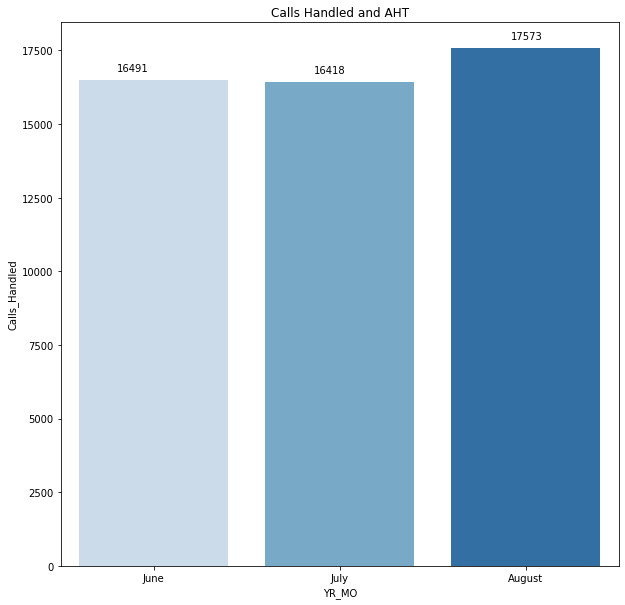

In [15]:
fig_dims = (10, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x='YR_MO', y='Calls_Handled',ax=ax, data=df, palette='Blues').set_title('Calls Handled and AHT')
initialx = -1
for p in ax.patches:
    ax.annotate(('{:1.0f}'.format(p.get_height())), ((p.get_width()+initialx), p.get_height() * 1.018))
    initialx+=1.06
    

In [16]:
m = df['Avg_Handle_time'].mean()

Average Handle Time for the months June, July and August

Text(0.5, 1.0, 'Calls Handled and AHT')

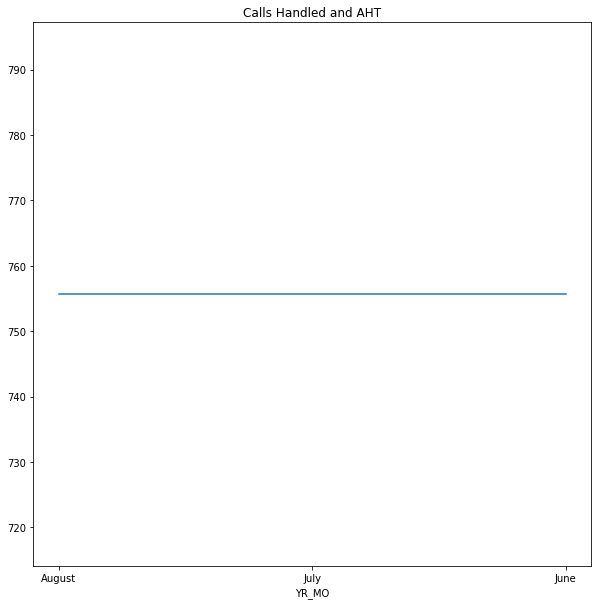

In [17]:
fig_dims = (10, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.lineplot(x='YR_MO', y=m,ax=ax, data=df).set_title('Calls Handled and AHT')

Combo Chart for Calls Handled and AHT for the months' June, July and August

Sharp increase in number of calls handled. AHT remains relatively flat.

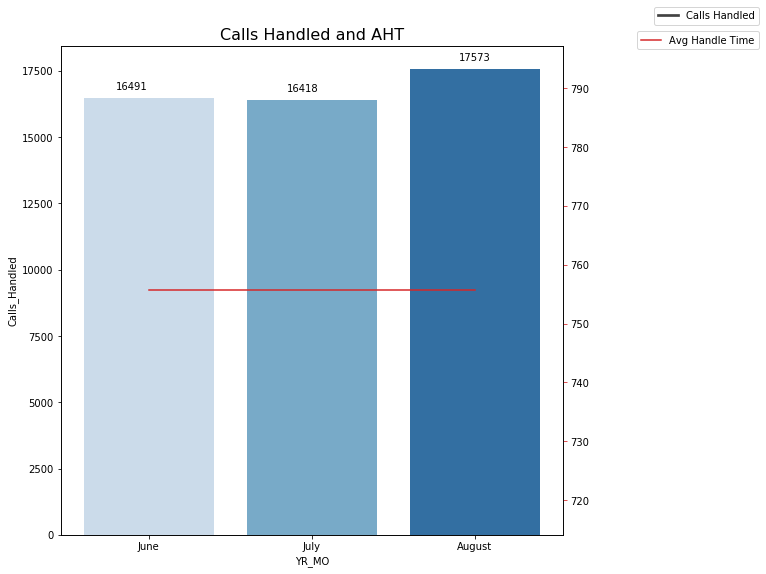

In [18]:
#Create combo chart
fig, ax1 = plt.subplots(figsize=(9,9))
color = 'tab:blue'
#bar plot creation
ax1.set_title('Calls Handled and AHT', fontsize=16)
ax1 = sns.barplot(x='YR_MO', y='Calls_Handled',data=df, palette='Blues')
ax1.legend(['Calls Handled'],bbox_to_anchor=(1.4, 1.09))
initialx = -1
for p in ax1.patches:
    ax1.annotate(str(('{:1.0f}'.format(p.get_height()))), ((p.get_width()+initialx), p.get_height() * 1.018))
    initialx+=1.05
#ax1.tick_params(axis='y')
#specify we want to share the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
#line plot creation
sns.lineplot(x='YR_MO', y=m, data=df, sort=False, color=color)
#tick_params used to change appearance of ticks and ticks labels
ax2.tick_params(axis='y', color=color)
#plt.legend(labels = ['Avg Handle Time','Calls Handled'],bbox_to_anchor=(1.4, 1.05))
ax2.legend(['Avg Handle Time'],bbox_to_anchor=(1.4, 1.04))
#show plot
plt.show()

In [19]:
AHT_data = df

In [20]:
AHT_data = AHT_data.drop(['Calls_Handled','Transfer%','Offer%','Accept%','Applied%','Breakage','Applied_Per_Call','Callbck_in_2days'],axis=1)

In [21]:
AHT_data['AHT Target'] = 780

AHT_data.loc[1,'AHT Target'] = 783

AHT_data.loc[2,'AHT Target'] = 775

In [22]:
AHT_data['Avg_Handle_time'] = AHT_data['Avg_Handle_time'].astype('int64')





Average Handle Time vs AHT_Target for the months' June, July, August.

AHT still below target. The target was dropped in August.





Text(0.5, 1.0, 'AHT vs Target')

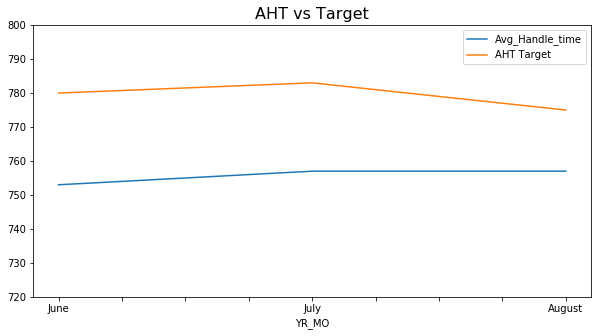

In [23]:
AHT_data.plot(x ='YR_MO',y=['Avg_Handle_time','AHT Target'], figsize=(10,5),ylim=(720,800)).set_title('AHT vs Target', fontsize=16)

Graph of Applied Per Call% vs Breakage% for the months' June, July and August.


Breakage dropped in July and August, but Applied Per Call is about the same.


Text(0.5, 1.0, 'Applied_per_call and Breakage')

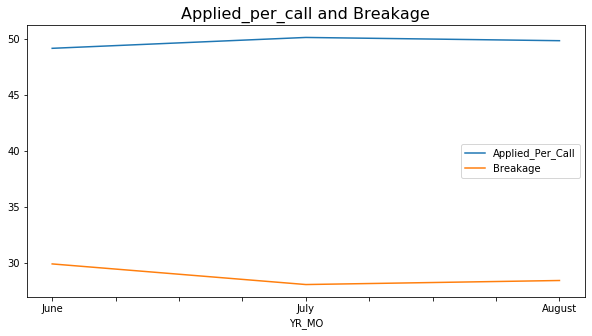

In [24]:
df.plot(x ='YR_MO',y=['Applied_Per_Call','Breakage'], figsize=(10,5)).set_title('Applied_per_call and Breakage', fontsize=16)

In [25]:
df['app_per_call_tgt'][0] = 50.5
df['app_per_call_tgt'][1] = 50.9
df['app_per_call_tgt'][2] = 50.1

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
df['transfer_tgt'][0] = 8.2
df['transfer_tgt'][1] = 8.1
df['transfer_tgt'][2] = 7.5

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
df.loc[0,'call_regen_target']=16.7
df.loc[1,'call_regen_target']=16.2
df.loc[2,'call_regen_target']=16.9

Graph of Applied Per Call% vs Applied Per Call Target for the months' June, July, August

Applied Per Call is still below target. APC training classes begin in September.


Text(0.5, 1.0, 'Applied_per_call vs Target')

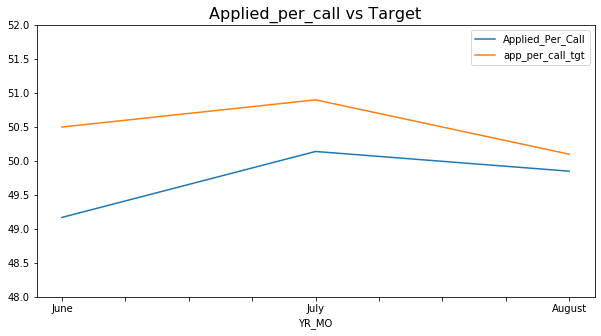

In [28]:
df.plot(x ='YR_MO',y=['Applied_Per_Call','app_per_call_tgt'], figsize=(10,5),ylim=(48,52)).set_title('Applied_per_call vs Target', fontsize=16)

Graph of Transfer% vs Transfer Target for months' June, July and August.


Transfers dropped significantly following Transfer Reduction training in July.


Text(0.5, 1.0, 'Transfers vs Target')

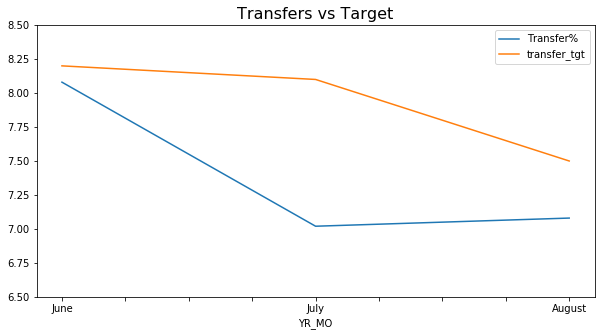

In [29]:
df.plot(x ='YR_MO',y=['Transfer%','transfer_tgt'], figsize=(10,5),ylim=(6.5,8.5)).set_title('Transfers vs Target', fontsize=16)

Graph of Callback within 2 days vs Call Regen Target for the months' of June, July and August.


Call Regeneration remains high, and the drop in target does not appear to have had any effect.


Text(0.5, 1.0, 'Call Regen vs Target')

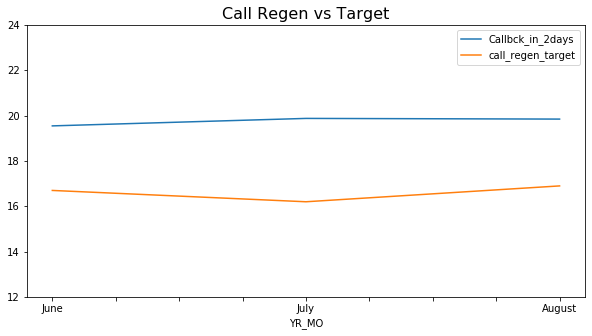

In [30]:
df.plot(x ='YR_MO',y=['Callbck_in_2days','call_regen_target'], figsize=(10,5),ylim=(12,24)).set_title('Call Regen vs Target', fontsize=16)

In [31]:
colns = ['Calls w/no Offer','Calls w/Offer Declined','Calls Accepted not applied','Calls w/Offer Applied']

Calls_Offer = pd.DataFrame(columns = colns)

In [32]:
Calls_Offer['Calls w/Offer Applied'] = data.groupby('YR_MO').sum()['CALLS_OFFER_APPLIED']

Calls_Offer['Calls Accepted not applied'] = data.groupby('YR_MO').sum()['CALLS_WITH_ACCEPT'] - Calls_Offer['Calls w/Offer Applied']

Calls_Offer['Calls w/Offer Declined'] = data.groupby('YR_MO').sum()['CALLS_WITH_OFFER'] - data.groupby('YR_MO').sum()['CALLS_WITH_ACCEPT']

Calls_Offer['Calls w/no Offer'] = data.groupby('YR_MO').sum()['CALLS'] - data.groupby('YR_MO').sum()['CALLS_WITH_OFFER']

In [33]:
Calls_Offer = Calls_Offer.reset_index()

In [34]:
Calls_Offer['YR_MO'] = AHT_data['YR_MO']

In [35]:
Calls_Offer

,YR_MO,Calls w/no Offer,Calls w/Offer Declined,Calls Accepted not applied,Calls w/Offer Applied
0,June,1238,3682,3463,8108
1,July,1208,3763,3215,8232
2,August,1290,4039,3484,8760


In [36]:
x = Calls_Offer[['YR_MO','Calls w/no Offer','Calls w/Offer Declined','Calls Accepted not applied','Calls w/Offer Applied']]

In [37]:
y= x.set_index('YR_MO')

In [38]:
z = y.groupby('YR_MO').sum()

The number of Applied offers increased in August, but so did the number of Declined offers.


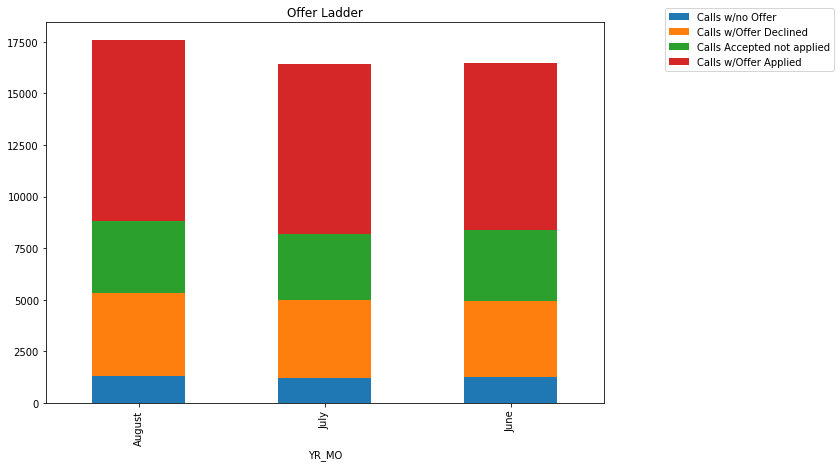

In [39]:
ax = z.plot.bar( stacked=True, title='Offer Ladder',figsize=(10,7), legend=False)
ax.legend(bbox_to_anchor=(1.1, 1.05))

<h1>Supervisor Snapshot<h1>

In [40]:
colmns = ['Calls_Handled','Avg_Handle_Time','Transfer%','Offer%','Accept%','Applied%','Breakage','Applied_Per_Call','Callback_within_2days']

In [41]:
Supervisor = pd.DataFrame(columns = colmns)

In [42]:
Supervisor['Calls_Handled'] = data.groupby('TEAM_LEAD_ID').sum()['CALLS']

Supervisor['Avg_Handle_Time'] = (data.groupby('TEAM_LEAD_ID').sum()['HANDLE_TIME']/data.groupby('TEAM_LEAD_ID').sum()['CALLS']).round(decimals=0).astype(int)

Supervisor['Transfer%'] = (data.groupby('TEAM_LEAD_ID').sum()['TRANSFERS']/data.groupby('TEAM_LEAD_ID').sum()['CALLS']).round(decimals = 4)*100

Supervisor['Offer%'] = (data.groupby('TEAM_LEAD_ID').sum()['CALLS_WITH_OFFER']/data.groupby('TEAM_LEAD_ID').sum()['CALLS']).round(decimals = 4)*100

Supervisor['Accept%'] = (data.groupby('TEAM_LEAD_ID').sum()['CALLS_WITH_ACCEPT']/data.groupby('TEAM_LEAD_ID').sum()['CALLS_WITH_OFFER']).round(decimals = 4)*100

Supervisor['Applied%'] = (data.groupby('TEAM_LEAD_ID').sum()['CALLS_OFFER_APPLIED']/data.groupby('TEAM_LEAD_ID').sum()['CALLS_WITH_ACCEPT']).round(decimals = 4)*100

Supervisor['Breakage'] = ((data.groupby('TEAM_LEAD_ID').sum()['CALLS_WITH_ACCEPT']-data.groupby('TEAM_LEAD_ID').sum()['CALLS_OFFER_APPLIED'])/data.groupby('TEAM_LEAD_ID').sum()['CALLS_WITH_ACCEPT']).round(decimals = 4)*100

Supervisor['Applied_Per_Call'] = (data.groupby('TEAM_LEAD_ID').sum()['CALLS_OFFER_APPLIED']/data.groupby('TEAM_LEAD_ID').sum()['CALLS']).round(decimals = 4)*100

Supervisor['Callback_within_2days'] = (data.groupby('TEAM_LEAD_ID').sum()['CALL_REGEN']/data.groupby('TEAM_LEAD_ID').sum()['CALLS']).round(decimals = 4)*100

In [43]:
Supervisor = Supervisor.reset_index()

In [44]:
#Supervisor = Supervisor.append(Supervisor.mean(numeric_only=True), ignore_index=True)
Supervisor.loc['Grand_Total']= Supervisor.mean(numeric_only=True, axis=0)

In [45]:
Supervisor['TEAM_LEAD_ID'][3] = 0
Supervisor['Calls_Handled'][3] = Supervisor['Calls_Handled'][0] + Supervisor['Calls_Handled'][1] + Supervisor['Calls_Handled'][2]

In [46]:
Supervisor['TEAM_LEAD_ID'] = Supervisor['TEAM_LEAD_ID'].astype(int)
Supervisor['Calls_Handled'] = Supervisor['Calls_Handled'].astype(int)

In [47]:
Supervisor['Transfer%']  = Supervisor['Transfer%'].round(decimals = 1).map(str) + '%'
Supervisor['Avg_Handle_Time'] = Supervisor['Avg_Handle_Time'].round(decimals = 0) 
Supervisor['Offer%'] = Supervisor['Offer%'].round(decimals = 1).map(str) + '%'
Supervisor['Accept%'] = Supervisor['Accept%'].round(decimals = 1).map(str) + '%'
Supervisor['Applied%'] = Supervisor['Applied%'].round(decimals = 1).map(str) + '%'
Supervisor['Breakage'] = Supervisor['Breakage'].round(decimals = 1).map(str) + '%'
Supervisor['Applied_Per_Call'] = Supervisor['Applied_Per_Call'].round(decimals = 1).map(str) + '%'
Supervisor['Callback_within_2days'] = Supervisor['Callback_within_2days'].round(decimals = 1).map(str) + '%'

Supervisor Details based across given metrics

In [48]:
Supervisor

,TEAM_LEAD_ID,Calls_Handled,Avg_Handle_Time,Transfer%,Offer%,Accept%,Applied%,Breakage,Applied_Per_Call,Callback_within_2days
0,201700011,18233,695.0,4.6%,95.0%,80.0%,80.3%,19.7%,61.0%,14.8%
1,201700012,16212,759.0,6.8%,92.5%,75.3%,70.2%,29.8%,48.9%,20.3%
2,201700013,16037,821.0,11.1%,90.0%,70.1%,59.8%,40.2%,37.7%,24.8%
Grand_Total,0,50482,758.0,7.5%,92.5%,75.1%,70.1%,29.9%,49.2%,20.0%


<h1>Agent Snapshot<h1>

In [49]:
colmns = ['Agent_name','Calls_Handled','Avg_Handle_Time','Transfer%','Offer%','Accept%','Applied%','Breakage','Applied_Per_Call','Callback_within_2days']

Agent = pd.DataFrame(columns = colmns)

In [50]:
Agent['Calls_Handled'] = data.groupby('AGENT_ID').sum()['CALLS']

Agent['Avg_Handle_Time'] = (data.groupby('AGENT_ID').sum()['HANDLE_TIME']/data.groupby('AGENT_ID').sum()['CALLS']).round(decimals=0).astype(int)

Agent['Transfer%'] = (data.groupby('AGENT_ID').sum()['TRANSFERS']/data.groupby('AGENT_ID').sum()['CALLS']).round(decimals = 4)*100

Agent['Offer%'] = (data.groupby('AGENT_ID').sum()['CALLS_WITH_OFFER']/data.groupby('AGENT_ID').sum()['CALLS']).round(decimals = 4)*100

Agent['Accept%'] = (data.groupby('AGENT_ID').sum()['CALLS_WITH_ACCEPT']/data.groupby('AGENT_ID').sum()['CALLS_WITH_OFFER']).round(decimals = 4)*100

Agent['Applied%'] = (data.groupby('AGENT_ID').sum()['CALLS_OFFER_APPLIED']/data.groupby('AGENT_ID').sum()['CALLS_WITH_ACCEPT']).round(decimals = 4)*100

Agent['Breakage'] = ((data.groupby('AGENT_ID').sum()['CALLS_WITH_ACCEPT']-data.groupby('AGENT_ID').sum()['CALLS_OFFER_APPLIED'])/data.groupby('AGENT_ID').sum()['CALLS_WITH_ACCEPT']).round(decimals = 4)*100

Agent['Applied_Per_Call'] = (data.groupby('AGENT_ID').sum()['CALLS_OFFER_APPLIED']/data.groupby('AGENT_ID').sum()['CALLS']).round(decimals = 4)*100

Agent['Callback_within_2days'] = (data.groupby('AGENT_ID').sum()['CALL_REGEN']/data.groupby('AGENT_ID').sum()['CALLS']).round(decimals = 4)*100

In [51]:
Agent = Agent.reset_index()

In [52]:
temp = data[data.columns[2:4]].drop_duplicates()

In [53]:
temp = temp.sort_values(by = 'AGENT_ID')
temp = temp.reset_index()

In [54]:
Agent = Agent.sort_values(by = 'AGENT_ID')

In [55]:
Agent['Agent_name'] = temp['AGENT_NAME']

In [56]:
#Agent = Agent.append(Agent.mean(numeric_only=True).rename('Grand_Total'), ignore_index=True)
Agent.loc['Grand_Total']= Agent.mean(numeric_only=True, axis=0)

In [57]:
Agent['AGENT_ID'][25] = 0
Agent['Calls_Handled'][25] = 0 
Agent['Calls_Handled'][25] = Agent['Calls_Handled'].sum()

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [58]:
Agent['Transfer%']  = Agent['Transfer%'].round(decimals = 1).map(str) + '%'
Agent['Calls_Handled'] = Agent['Calls_Handled'].round(decimals = 0)
Agent['Avg_Handle_Time'] = Agent['Avg_Handle_Time'].round(decimals = 0) 
Agent['Offer%'] = Agent['Offer%'].round(decimals = 1).map(str) + '%'
Agent['Accept%'] = Agent['Accept%'].round(decimals = 1).map(str) + '%'
Agent['Applied%'] = Agent['Applied%'].round(decimals = 1).map(str) + '%'
Agent['Breakage'] = Agent['Breakage'].round(decimals = 1).map(str) + '%'
Agent['Applied_Per_Call'] = Agent['Applied_Per_Call'].round(decimals = 1).map(str) + '%'
Agent['Callback_within_2days'] = Agent['Callback_within_2days'].round(decimals = 1).map(str) + '%'

In [59]:
Agent['AGENT_ID'] = Agent['AGENT_ID'].astype(int)
Agent['Calls_Handled'] = Agent['Calls_Handled'].astype(int)

Agent Details based across given metrics

In [60]:
Agent

,AGENT_ID,Agent_name,Calls_Handled,Avg_Handle_Time,Transfer%,Offer%,Accept%,Applied%,Breakage,Applied_Per_Call,Callback_within_2days
0,201700121,"Anderson, Albert",2149,684.0,4.9%,94.6%,79.6%,78.8%,21.2%,59.4%,15.2%
1,201700122,"Binning, Bart",2347,692.0,4.4%,95.1%,79.9%,80.5%,19.5%,61.2%,14.7%
2,201700123,"Centerville, Cece",2319,699.0,4.7%,95.6%,81.6%,79.6%,20.4%,62.0%,14.7%
3,201700124,"Davenport, Davina",2282,690.0,4.8%,94.6%,79.1%,80.8%,19.2%,60.5%,14.4%
4,201700125,"Edgerton, Ethan",2288,699.0,4.5%,94.7%,80.2%,81.6%,18.4%,61.9%,15.0%
5,201700126,"Filipsano, Fiona",2312,701.0,4.6%,94.9%,80.8%,80.8%,19.2%,62.0%,14.8%
6,201700127,"Gee, Garry",2402,688.0,4.5%,95.3%,79.2%,79.3%,20.7%,59.9%,15.2%
7,201700128,"Harrison, Harold",2134,707.0,4.4%,95.6%,79.6%,80.7%,19.3%,61.4%,14.6%
8,201700129,"Ivanski, Igor",2093,751.0,7.1%,93.3%,74.9%,69.4%,30.6%,48.4%,20.3%
9,201700130,"Jeffries, Johnna",2135,764.0,6.7%,91.5%,74.8%,69.3%,30.7%,47.4%,20.9%


<h1>Outliers<h1>

<h3>AHT Over 800 Seconds<h3>

In [61]:
AHT_Outliers = Agent

In [62]:
AHT_Outliers = AHT_Outliers.drop(['Calls_Handled','Transfer%','Offer%','Accept%','Applied%','Breakage','Applied_Per_Call','Callback_within_2days'],axis = 1)

In [63]:
AHT_Outliers = AHT_Outliers[AHT_Outliers['Avg_Handle_Time'] > 800]

AHT Outliers Over 800 Seconds for the Agent

In [64]:
AHT_Outliers

,AGENT_ID,Agent_name,Avg_Handle_Time
17,201700138,"Sanders, Sammi",825.0
18,201700139,"Thomas, Ted",823.0
19,201700140,"Uvaldon, Ursala",824.0
20,201700141,"Vindictive, Vinny",818.0
21,201700142,"Williamson, Wilma",815.0
22,201700143,"Younger, Yeti",827.0
23,201700144,"Zwilowski, Zane",818.0
24,201700145,"Abacus, Aaron",822.0


<h3>Transfer % Over 7%<h3>

In [65]:
cols = ['AGENT_ID','Agent_Name','Transfer%']

Transfer_Outliers = pd.DataFrame(columns = cols)

temp = (data.groupby('AGENT_ID').sum()['TRANSFERS']/data.groupby('AGENT_ID').sum()['CALLS']).round(decimals = 3)*100
temp = temp.reset_index()
Transfer_Outliers['Transfer%'] = temp[0]

In [66]:
Transfer_Outliers['Agent_Name'] = Agent['Agent_name']

Transfer_Outliers['AGENT_ID'] = Agent['AGENT_ID']

Transfer% Outliers Over 7% for the Agents

In [67]:
Transfer_Outliers = Transfer_Outliers[Transfer_Outliers['Transfer%']>7]

Transfer_Outliers['Transfer%'] = Transfer_Outliers['Transfer%'].round(decimals=1).map(str) + '%'

Transfer_Outliers

Transfer_Outliers.style.set_properties(**{'background-color': 'LightGrey'})

,AGENT_ID,Agent_Name,Transfer%
8,201700129,"Ivanski, Igor",7.1%
15,201700136,"Pulaski, Peter",9.8%
17,201700138,"Sanders, Sammi",11.3%
18,201700139,"Thomas, Ted",11.2%
19,201700140,"Uvaldon, Ursala",11.4%
20,201700141,"Vindictive, Vinny",11.0%
21,201700142,"Williamson, Wilma",10.8%
22,201700143,"Younger, Yeti",11.0%
23,201700144,"Zwilowski, Zane",11.0%
24,201700145,"Abacus, Aaron",11.0%


<h3>Offer% Under 92%<h3>

In [68]:
cols = ['AGENT_ID','Agent_Name','Offer%']

Offer_Outliers = pd.DataFrame(columns = cols)

temp = (data.groupby('AGENT_ID').sum()['CALLS_WITH_OFFER']/data.groupby('AGENT_ID').sum()['CALLS']).round(decimals = 3)*100
temp = temp.reset_index()
Offer_Outliers['Offer%'] = temp[0]

In [69]:
Offer_Outliers['Agent_Name'] = Agent['Agent_name']
Offer_Outliers['AGENT_ID'] = Agent['AGENT_ID']

Offer% Outliers identified with Offer% under 92%

In [70]:
Offer_Outliers = Offer_Outliers[Offer_Outliers['Offer%']<92]

Offer_Outliers['Offer%'] = Offer_Outliers['Offer%'].round(decimals=1).map(str) + '%'

Offer_Outliers

Offer_Outliers.style.set_properties(**{'background-color': 'LightBlue'})

,AGENT_ID,Agent_Name,Offer%
9,201700130,"Jeffries, Johnna",91.5%
12,201700133,"Myers, Matt",91.7%
13,201700134,"Nichols, Nana",91.3%
15,201700136,"Pulaski, Peter",91.2%
17,201700138,"Sanders, Sammi",89.9%
18,201700139,"Thomas, Ted",89.9%
19,201700140,"Uvaldon, Ursala",89.9%
20,201700141,"Vindictive, Vinny",90.1%
21,201700142,"Williamson, Wilma",90.1%
22,201700143,"Younger, Yeti",90.0%


<h3>Applied Per Call Under 50%<h3>

In [71]:
cols = ['AGENT_ID','Agent_Name','Applied_Per_Call']

Applied_Per_Call_Outliers = pd.DataFrame(columns = cols)

temp = (data.groupby('AGENT_ID').sum()['CALLS_OFFER_APPLIED']/data.groupby('AGENT_ID').sum()['CALLS']).round(decimals = 3)*100
temp = temp.reset_index()
Applied_Per_Call_Outliers['Applied_Per_Call'] = temp[0]

In [72]:
Applied_Per_Call_Outliers['Agent_Name'] = Agent['Agent_name']
Applied_Per_Call_Outliers['AGENT_ID'] = Agent['AGENT_ID']

Applied Per Call% Outliers identified with Applied_Per_Call% Under 50%

In [73]:
Applied_Per_Call_Outliers = Applied_Per_Call_Outliers[Applied_Per_Call_Outliers['Applied_Per_Call']<50]

Applied_Per_Call_Outliers['Applied_Per_Call'] = Applied_Per_Call_Outliers['Applied_Per_Call'].round(decimals=1).map(str) + '%'

Applied_Per_Call_Outliers

Applied_Per_Call_Outliers.style.set_properties(**{'background-color': 'Orange'})

,AGENT_ID,Agent_Name,Applied_Per_Call
8,201700129,"Ivanski, Igor",48.4%
9,201700130,"Jeffries, Johnna",47.4%
10,201700131,"Kippers, Kat",49.6%
12,201700133,"Myers, Matt",48.4%
13,201700134,"Nichols, Nana",48.7%
14,201700135,"Ohlson, Octavius",48.6%
15,201700136,"Pulaski, Peter",43.5%
16,201700137,"Rank, Richelle",48.5%
17,201700138,"Sanders, Sammi",37.6%
18,201700139,"Thomas, Ted",36.7%


<h3>Callback Within 2 days over 20%<h3>

In [74]:
cols = ['AGENT_ID','Agent_Name','Callback_Within_2days']

Callback_Outliers = pd.DataFrame(columns = cols)

temp = (data.groupby('AGENT_ID').sum()['CALL_REGEN']/data.groupby('AGENT_ID').sum()['CALLS']).round(decimals = 3)*100
temp = temp.reset_index()
Callback_Outliers['Callback_Within_2days'] = temp[0]

In [75]:
Callback_Outliers['Agent_Name'] = Agent['Agent_name']
Callback_Outliers['AGENT_ID'] = Agent['AGENT_ID']

Callback Within 2Days Outliers identified with Callback_Within_2days over 20%

In [76]:
Callback_Outliers = Callback_Outliers[Callback_Outliers['Callback_Within_2days']>20]

Callback_Outliers['Callback_Within_2days'] = Callback_Outliers['Callback_Within_2days'].round(decimals=1).map(str) + '%'

Callback_Outliers

Callback_Outliers.style.set_properties(**{'background-color': 'LightGreen'})

,AGENT_ID,Agent_Name,Callback_Within_2days
8,201700129,"Ivanski, Igor",20.3%
9,201700130,"Jeffries, Johnna",20.9%
11,201700132,"Lipp, Larry",20.1%
12,201700133,"Myers, Matt",20.4%
13,201700134,"Nichols, Nana",21.0%
14,201700135,"Ohlson, Octavius",20.2%
15,201700136,"Pulaski, Peter",22.2%
16,201700137,"Rank, Richelle",20.4%
17,201700138,"Sanders, Sammi",24.9%
18,201700139,"Thomas, Ted",24.3%


<h3>Outlier List<h3>

In [111]:
def color_negative_red(val):
    """
    Takes value yes and returns a string with
    the css property `'color: red'` , black otherwise.
    """
    color = 'red' if val == 'Yes' else 'black'
    return 'color: %s' % color

In [112]:
cols = ['AGENT_ID','Agent_Name']

Outliers_list = pd.DataFrame(columns = cols)

Outliers_list['Agent_Name'] = Agent['Agent_name']
Outliers_list['AGENT_ID'] = Agent['AGENT_ID']

In [113]:
Outliers_list = pd.merge(Outliers_list,AHT_Outliers[['AGENT_ID','Avg_Handle_Time']],on='AGENT_ID', how='left')

Outliers_list = pd.merge(Outliers_list,Transfer_Outliers[['AGENT_ID','Transfer%']],on='AGENT_ID', how='left')

Outliers_list = pd.merge(Outliers_list,Offer_Outliers[['AGENT_ID','Offer%']],on='AGENT_ID', how='left')

Outliers_list = pd.merge(Outliers_list,Applied_Per_Call_Outliers[['AGENT_ID','Applied_Per_Call']],on='AGENT_ID', how='left')

Outliers_list = pd.merge(Outliers_list,Callback_Outliers[['AGENT_ID','Callback_Within_2days']],on='AGENT_ID', how='left')

In [114]:
Outliers_list.columns = ['AGENT_ID','Agent_Name','AHT Over 800 Seconds','Tranfer% Over 7%','Offer% Under 92%','Applied Per Call Under 50%','Callback within 2 days over 20%']

In [115]:
for i in range(0,25):
    if Outliers_list.iloc[i,2:].notnull().values.any()==True :
        Outliers_list.loc[i,'Outlier'] = 'Yes'

In [116]:
Outliers_list['AHT Over 800 Seconds'] = Outliers_list['AHT Over 800 Seconds'].round(decimals = 1)

In [117]:
Outliers_list.dropna(subset = ["Agent_Name"], inplace=True)
Outliers_list = Outliers_list.fillna('-')

Aggregated Agent View with Agents identified across metrics which have Outliers

In [118]:
s = Outliers_list.style.applymap(color_negative_red)
s

,AGENT_ID,Agent_Name,AHT Over 800 Seconds,Tranfer% Over 7%,Offer% Under 92%,Applied Per Call Under 50%,Callback within 2 days over 20%,Outlier
0,201700121,"Anderson, Albert",-,-,-,-,-,-
1,201700122,"Binning, Bart",-,-,-,-,-,-
2,201700123,"Centerville, Cece",-,-,-,-,-,-
3,201700124,"Davenport, Davina",-,-,-,-,-,-
4,201700125,"Edgerton, Ethan",-,-,-,-,-,-
5,201700126,"Filipsano, Fiona",-,-,-,-,-,-
6,201700127,"Gee, Garry",-,-,-,-,-,-
7,201700128,"Harrison, Harold",-,-,-,-,-,-
8,201700129,"Ivanski, Igor",-,7.1%,-,48.4%,20.3%,Yes
9,201700130,"Jeffries, Johnna",-,-,91.5%,47.4%,20.9%,Yes


In [85]:
columns = ['Avg_Handle_time','Calls_Handled','Transfer%','Offer%','Accept%','Applied%','Breakage','Applied_Per_Call','Callbck_in_2days']
pred = pd.DataFrame(columns = columns)

In [86]:
pred['Avg_Handle_time'] = (data.groupby(['YR_MO','AGENT_ID']).sum()['HANDLE_TIME']/data.groupby(['YR_MO','AGENT_ID']).sum()['CALLS']).round(decimals=0)

pred['Calls_Handled'] = data.groupby(['YR_MO','AGENT_ID']).sum()['CALLS']

pred['Transfer%'] = (data.groupby(['YR_MO','AGENT_ID']).sum()['TRANSFERS']/data.groupby(['YR_MO','AGENT_ID']).sum()['CALLS']).round(decimals = 4)*100

pred['Offer%'] = (data.groupby(['YR_MO','AGENT_ID']).sum()['CALLS_WITH_OFFER']/data.groupby(['YR_MO','AGENT_ID']).sum()['CALLS']).round(decimals = 4)*100

pred['Accept%'] = (data.groupby(['YR_MO','AGENT_ID']).sum()['CALLS_WITH_ACCEPT']/data.groupby(['YR_MO','AGENT_ID']).sum()['CALLS_WITH_OFFER']).round(decimals = 4)*100

pred['Applied%'] = (data.groupby(['YR_MO','AGENT_ID']).sum()['CALLS_OFFER_APPLIED']/data.groupby(['YR_MO','AGENT_ID']).sum()['CALLS_WITH_ACCEPT']).round(decimals = 4)*100

pred['Breakage'] = ((data.groupby(['YR_MO','AGENT_ID']).sum()['CALLS_WITH_ACCEPT']-data.groupby(['YR_MO','AGENT_ID']).sum()['CALLS_OFFER_APPLIED'])/data.groupby(['YR_MO','AGENT_ID']).sum()['CALLS_WITH_ACCEPT']).round(decimals = 4)*100

pred['Applied_Per_Call'] = (data.groupby(['YR_MO','AGENT_ID']).sum()['CALLS_OFFER_APPLIED']/data.groupby(['YR_MO','AGENT_ID']).sum()['CALLS']).round(decimals = 4)*100

pred['Callbck_in_2days'] = (data.groupby(['YR_MO','AGENT_ID']).sum()['CALL_REGEN']/data.groupby(['YR_MO','AGENT_ID']).sum()['CALLS']).round(decimals = 4)*100

In [87]:
pred

Avg_Handle_time  Calls_Handled  Transfer%  Offer%  Accept%  \
YR_MO  AGENT_ID                                                                
201706 201700121            687.0            797       6.02   93.98    78.10   
       201700122            701.0            783       5.75   95.40    79.65   
       201700123            701.0            784       6.25   95.92    82.58   
       201700124            683.0            730       5.48   93.29    79.30   
       201700125            706.0            777       5.92   93.69    78.98   
...                           ...            ...        ...     ...      ...   
201708 201700141            820.0            640      11.56   88.75    71.13   
       201700142            825.0            665      10.83   89.92    71.24   
       201700143            830.0            666      11.11   89.94    69.45   
       201700144            831.0            665      10.53   90.08    71.29   
       201700145            824.0            697      11.05   90.39    70.63   

                  Applied%  Breakage  Applied_Per_Call  Callbck_in_2days  
YR_MO  AGENT_ID                                                           
201706 201700121     79.15     20.85             58.09             14.30  
       201700122     79.66     20.34             60.54             14.56  
       201700123     81.00     19.00             64.16             15.18  
       201700124     81.48     18.52             60.27             14.52  
       201700125     80.00     20.00             59.20             15.57  
...                    ...       ...               ...               ...  
201708 201700141     60.64     39.36             38.28             24.69  
       201700142     64.08     35.92             41.05             24.66  
       201700143     62.50     37.50             39.04             24.47  
       201700144     60.66     39.34             38.95             24.81  
       201700145     62.25     37.75             39.74             24.96  

[74 rows x 9 columns]

In [88]:
pred = pred.reset_index()

In [89]:
pred = pred.sort_values(['AGENT_ID'])

In [90]:
pred

,YR_MO,AGENT_ID,Avg_Handle_time,Calls_Handled,Transfer%,Offer%,Accept%,Applied%,Breakage,Applied_Per_Call,Callbck_in_2days
0,201706,201700121,687.0,797,6.02,93.98,78.10,79.15,20.85,58.09,14.30
24,201707,201700121,706.0,601,3.83,95.34,81.85,76.97,23.03,60.07,15.14
49,201708,201700121,663.0,751,4.53,94.81,79.49,80.04,19.96,60.32,16.25
25,201707,201700122,691.0,761,3.55,95.14,79.28,82.23,17.77,62.02,14.85
1,201706,201700122,701.0,783,5.75,95.40,79.65,79.66,20.34,60.54,14.56
...,...,...,...,...,...,...,...,...,...,...,...
72,201708,201700144,831.0,665,10.53,90.08,71.29,60.66,39.34,38.95,24.81
47,201707,201700144,815.0,682,11.44,89.88,70.47,63.66,36.34,40.32,25.51
23,201706,201700145,820.0,490,10.82,89.39,70.78,52.26,47.74,33.06,24.90
48,201707,201700145,821.0,671,11.18,90.16,70.91,62.24,37.76,39.79,24.59


In [91]:
#pred = pred.drop(pred[pred['Avg_Handle_time']>800].index, inplace = True)
#pred = pred[pred['Avg_Handle_time']<800]

In [92]:
pred.shape

(74, 11)

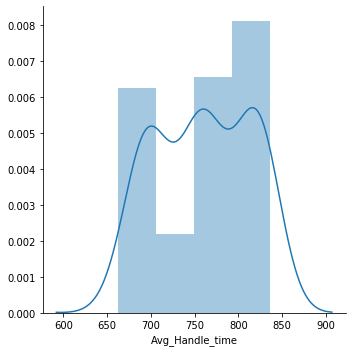

In [93]:
g= sns.FacetGrid(pred , height =5)
g.map(sns.distplot, 'Avg_Handle_time')

In [94]:
pred.corr()['Avg_Handle_time']

YR_MO               0.026048
AGENT_ID            0.933099
Avg_Handle_time     1.000000
Calls_Handled      -0.652803
Transfer%           0.934170
Offer%             -0.903286
Accept%            -0.930359
Applied%           -0.931934
Breakage            0.931934
Applied_Per_Call   -0.954123
Callbck_in_2days    0.959599
Name: Avg_Handle_time, dtype: float64

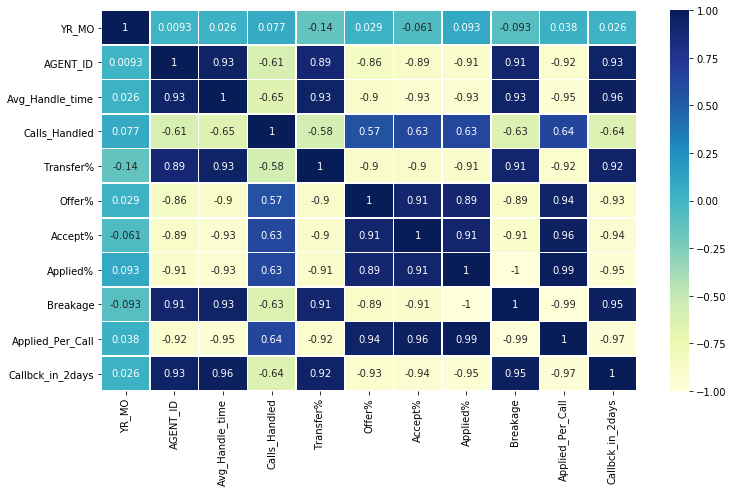

In [95]:
#correlation matrix to check the correlation between columns in the dataset
corrmat = pred.corr()
fig = plt.figure(figsize = (12, 7))
sns.heatmap(corrmat,cmap='YlGnBu', annot=True, linewidths=.5);
plt.show()

In [96]:
X = pd.DataFrame(pred[['AGENT_ID','Transfer%','Breakage','Callbck_in_2days']])
y = pd.DataFrame(pred['Avg_Handle_time'])

In [97]:
model = LinearRegression()
scores = []
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
for i, (train, test) in enumerate(kfold.split(X, y)):
 model.fit(X.iloc[train,:], y.iloc[train,:])
 score = model.score(X.iloc[test,:], y.iloc[test,:])
 scores.append(score*100)
print(scores)

[94.48970223937945, 94.67214479157607, 91.16918671322998]


In [98]:
corrmat

,YR_MO,AGENT_ID,Avg_Handle_time,Calls_Handled,Transfer%,Offer%,Accept%,Applied%,Breakage,Applied_Per_Call,Callbck_in_2days
YR_MO,1.000000,0.009294,0.026048,0.077329,-0.135376,0.028626,-0.061265,0.092897,-0.092897,0.038226,0.026128
AGENT_ID,0.009294,1.000000,0.933099,-0.607851,0.885437,-0.863493,-0.890702,-0.907662,0.907662,-0.922273,0.932333
Avg_Handle_time,0.026048,0.933099,1.000000,-0.652803,0.934170,-0.903286,-0.930359,-0.931934,0.931934,-0.954123,0.959599
Calls_Handled,0.077329,-0.607851,-0.652803,1.000000,-0.577954,0.568878,0.627103,0.634535,-0.634535,0.644450,-0.644108
Transfer%,-0.135376,0.885437,0.934170,-0.577954,1.000000,-0.904967,-0.901792,-0.906534,0.906534,-0.924200,0.922722
Offer%,0.028626,-0.863493,-0.903286,0.568878,-0.904967,1.000000,0.910371,0.892700,-0.892700,0.936638,-0.927905
Accept%,-0.061265,-0.890702,-0.930359,0.627103,-0.901792,0.910371,1.000000,0.906268,-0.906268,0.959201,-0.937968
Applied%,0.092897,-0.907662,-0.931934,0.634535,-0.906534,0.892700,0.906268,1.000000,-1.000000,0.985692,-0.953211
Breakage,-0.092897,0.907662,0.931934,-0.634535,0.906534,-0.892700,-0.906268,-1.000000,1.000000,-0.985692,0.953211
Applied_Per_Call,0.038226,-0.922273,-0.954123,0.644450,-0.924200,0.936638,0.959201,0.985692,-0.985692,1.000000,-0.974353


In [99]:
selected_columns = ['AGENT_ID','Transfer%','Breakage','Callbck_in_2days']

In [100]:
#selected_columns = pred.columns[columns]
data_selected = pred[selected_columns]

In [101]:
#moving the result to a new dataframe

result = pd.DataFrame()
result['Avg_Handle_time'] = pred.iloc[:,2]

In [102]:
#creating a dataframe using columns selected using correlation

data_final = pd.DataFrame(data = data_selected, columns = selected_columns)
data_final.head(3)

,AGENT_ID,Transfer%,Breakage,Callbck_in_2days
0,201700121,6.02,20.85,14.30
24,201700121,3.83,23.03,15.14
49,201700121,4.53,19.96,16.25


In [103]:
x_train, x_test, y_train, y_test = train_test_split(data_final, result, test_size = 0.1,random_state = 101)

In [104]:
y_train = y_train.astype(int)

In [105]:
# Initialize the model class.
model = LinearRegression()

model.fit(x_train, y_train)

# Import the scikit-learn function to compute error.
from sklearn.metrics import mean_squared_error

# Generate our predictions for the test set.
Y_pred = model.predict(x_test)

# Compute error between our test predictions and the actual values.
mean_squared_error(Y_pred, y_test)

219.7105052992069

In [123]:
#find R Square for the model

model.score(x_train,y_train)*100

94.87346579783086

<h4>The accuracy received for the prediction of Average Handle Time is 94.87%</h4>